## Plot Energi Kumulatif versi 1.0

### Plot Energi Kumulatif dan Jumlah Gempa
Gunakan cell di bawah untuk mengeplot energi kumulatif yang dioverlay dengan jumlah gempa

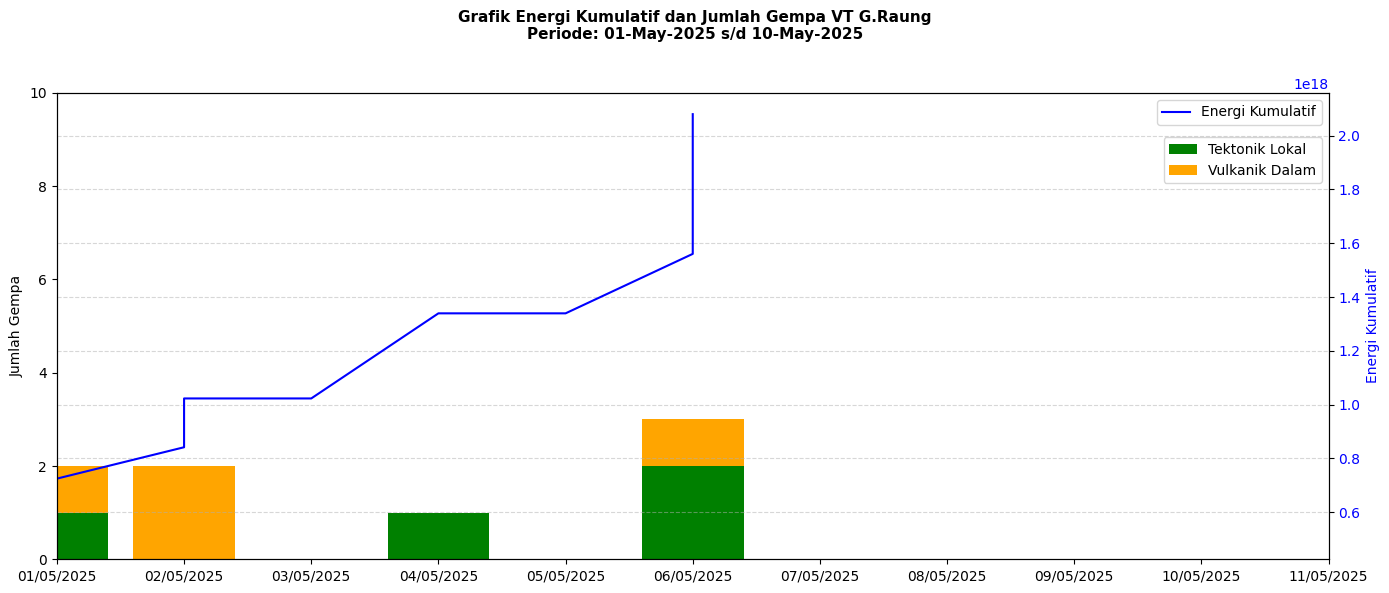

Tabel Gempa


,Tanggal,Waktu tiba,Amplituda,S-P,Durasi,Magnitudo,Energi,Energi kumulatif,Type gempa
0,2025-05-01,01:03:22,10,1.5,20,3.934967,504023676128412992,504023676128412992,Tektonik Lokal
1,2025-05-01,02:03:00,5,1.1,15,3.696334,221055567339622016,725079243468034944,Vulkanik Dalam
2,2025-05-02,13:10:55,7,1.6,12,3.511236,116641815289838000,841721058757873024,Vulkanik Dalam
3,2025-05-02,15:05:06,3,1.5,14,3.639105,181408161614088000,1023129220371960064,Vulkanik Dalam
5,2025-05-04,02:06:17,4,1.8,17,3.800157,316399770454625024,1339528990826589952,Tektonik Lokal
7,2025-05-06,17:18:03,8,2.1,15,3.696334,221055567339622016,1560584558166210048,Tektonik Lokal
8,2025-05-06,18:19:22,6,1.2,13,3.577632,146705942007180000,1707290500173390080,Vulkanik Dalam
9,2025-05-06,21:06:15,5,2.3,18,3.847570,372696854264420992,2079987354437809920,Tektonik Lokal


In [82]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# Definisikan path data dan nama gunung
path_file = "D:/Mukijo/logbook-vt.xlsx"
gunung = "Raung"

# Baris untuk diabaikan
baris_diabaikan = 2

# Tentukan tanggal awal, tanggal akhir, dan interval axis
waktu_awal = '01-05-2025'
waktu_akhir = '10-05-2025'
interval_hari = 1

# Axis y jumlah gempa
min_jumlah = 0
max_jumlah = 10
interval_jumlah = 2

tanggal_awal = pd.to_datetime(waktu_awal, format='%d-%m-%Y')
tanggal_akhir = pd.to_datetime(waktu_akhir, format='%d-%m-%Y')

data = pd.read_excel(path_file, skiprows=baris_diabaikan)
data = data.ffill()
data['Tanggal'] = pd.to_datetime(data['Tanggal'], unit='D', origin='1899-12-30')

nan_columns = ['Gerak awal', 'Frekuensi', 'Type gempa']

# Isi tanggal kosong dan buat baris dummy
new_rows = []
for i in range(1, len(data)):
    prev_time = data.iloc[i - 1]['Tanggal']
    curr_time = data.iloc[i]['Tanggal']
    time_diff = curr_time - prev_time

    if time_diff > pd.Timedelta(days=1):
        new_time = prev_time + pd.Timedelta(days=1)
        energi_sebelumnya = data.iloc[i - 1]['Energi kumulatif']
        while new_time < curr_time:
            new_row = []
            for col in data.columns:
                if col == 'Tanggal':
                    new_row.append(new_time)
                elif col == 'Waktu tiba':
                    new_row.append(pd.to_datetime('00:00:00').time())
                elif col in nan_columns:
                    new_row.append(np.nan)
                elif col == 'Energi kumulatif':
                    new_row.append(energi_sebelumnya)
                else:
                    new_row.append(0)
            new_rows.append(new_row)
            new_time += pd.Timedelta(days=1)

if new_rows:
    new_df = pd.DataFrame(new_rows, columns=data.columns)
    data = pd.concat([data, new_df], ignore_index=True)
    
# Gabungkan kolom Tanggal dan Waktu tiba
data = data.sort_values(by='Tanggal').reset_index(drop=True)
data['waktu_delta'] = data['Waktu tiba'].apply(lambda x: pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))
data['dateTime'] = data['Tanggal'] + data['waktu_delta']
data = data.drop(columns=['waktu_delta'])
data.insert(2, 'dateTime', data.pop('dateTime'))
data['dateTime'] = data['dateTime'].astype('int64')
data['dateTime'] = data['dateTime'].interpolate(method='linear')
data['dateTime'] = pd.to_datetime(data['dateTime'])
data['Energi_kumulatif'] = data['Energi'].cumsum()

# Filter baris dengan 'Type gempa' yang tidak kosong
filtered = data[~data['Type gempa'].isna()]
filtered = filtered[filtered['Type gempa'].isin(['Vulkanik Dalam', 'Tektonik Lokal'])]
gempa_per_day = filtered.groupby([filtered['Tanggal'].dt.date, 'Type gempa']).size().unstack(fill_value=0)

# Plot energi kumulatif
fig, ax1 = plt.subplots(figsize=(14, 6))

gempa_per_day.index = pd.to_datetime(gempa_per_day.index)
ax1.bar(gempa_per_day.index, gempa_per_day['Tektonik Lokal'],
        width=0.8, label='Tektonik Lokal', color='green')

ax1.bar(gempa_per_day.index, gempa_per_day['Vulkanik Dalam'],
        width=0.8, bottom=gempa_per_day['Tektonik Lokal'],
        label='Vulkanik Dalam', color='orange')

ax1.set_ylabel('Jumlah Gempa', color='black')
ax1.tick_params(axis='y', labelcolor='black')
y_ticks = mticker.MultipleLocator(interval_jumlah)
ax1.yaxis.set_major_locator(y_ticks)
ax1.set_ylim([min_jumlah, max_jumlah])
ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.92))

# Plot jumlah gempa VT
ax2 = ax1.twinx()
ax2.plot(data['Tanggal'], data['Energi_kumulatif'], color='blue', label='Energi Kumulatif')
ax2.set_ylabel('Energi Kumulatif', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
days = mdates.DayLocator(interval=interval_hari)
ax2.xaxis.set_major_locator(days)
ax2.tick_params(axis='x', rotation=90)
date_format = mdates.DateFormatter('%d/%m/%Y')
ax2.xaxis.set_major_formatter(date_format)
start_time = datetime.strptime(waktu_awal, '%d-%m-%Y')
end_time = datetime.strptime(waktu_akhir, '%d-%m-%Y')
ax2.set_xlim([start_time, end_time + timedelta(days=1)])
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(loc='upper right')

# Fungsi background jika diperlukan
def normal(start, end):
    plt.axvspan(start, end, facecolor='lime', alpha=0.35)

def waspada(start, end):
    plt.axvspan(start, end, facecolor='yellow', alpha=0.45)

def siaga(start, end):
    plt.axvspan(start, end, facecolor='orange', alpha=0.5)

def awas(start, end):
    plt.axvspan(start, end, facecolor='red', alpha=0.55)

# Memberi warna background sesuai status, ganti tanggal perubahan status sesuai histori, hapus/comment baris yang tidak perlu
# normal(pd.to_datetime('01/02/2025', format='%d/%m/%Y'), pd.to_datetime('28/02/2025', format='%d/%m/%Y'))
# waspada(pd.to_datetime('01/03/2025', format='%d/%m/%Y'), pd.to_datetime('31/04/2025', format='%d/%m/%Y'))
# siaga(pd.to_datetime('19/05/2023', format='%d/%m/%Y'), pd.to_datetime('31/08/2023', format='%d/%m/%Y'))
# awas(pd.to_datetime('21/07/2023', format='%d/%m/%Y'), pd.to_datetime('31/07/2023', format='%d/%m/%Y'))

# Judul
judul_grafik = f'Grafik Energi Kumulatif dan Jumlah Gempa VT G.{gunung}'
periode = f'Periode: {tanggal_awal.strftime("%d-%b-%Y")} s/d {tanggal_akhir.strftime("%d-%b-%Y")}'
plt.suptitle(f"{judul_grafik}\n{periode}\n", fontsize=11, fontweight='bold', ha='center')

fig.tight_layout()
plt.show()

print("Tabel Gempa")
filtered[["Tanggal", "Waktu tiba", "Amplituda", "S-P", "Durasi", "Magnitudo", "Energi", "Energi kumulatif", "Type gempa"]]



Contoh format Data logbook gempa:
https://docs.google.com/spreadsheets/d/1QrbC9U74uFvg-JJViCV9ESqKmRGMtwS7/edit?usp=sharing&ouid=101853471940845236138&rtpof=true&sd=true

Jumlah dan urutan kolom dalam tabel tidak harus sama, namun penamaan header kolom yang bersesuaian harus sama dengan contoh. Penamaan type gempa harus 'Vulkanik Dalam' untuk gempa Vulkanik dalam dan 'Tektonik Lokal' untuk gempa Tektonik lokal. Format tanggal dd/mm/yyyy dan format jam hh:mm:ss.